<a href="https://colab.research.google.com/github/csieuluoi/Tensorflow_selfstudying/blob/master/Neural_non_overlapping_segmenting_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prety CM

In [0]:
!pip install matplotlib==3.0
!pip install seaborn

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


__main__
_test_cm: test function with confusion matrix done
and pause


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


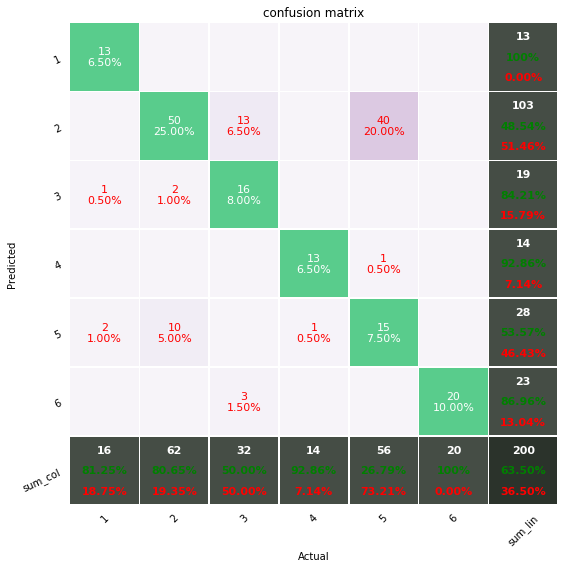

_test_data_class: test function with y_test (actual values) and predictions (predic)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


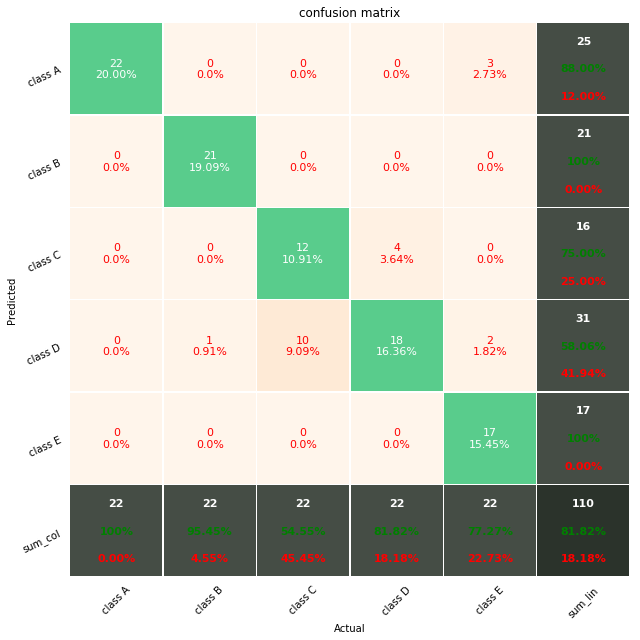

In [0]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
import os


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y', title = "confusion matrix", savefig = False, fig_dir = None, figname = 'confusion_matrix'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title(title)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    if savefig:
    	plt.savefig(os.path.join(fig_dir, figname)) 

    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin', title = 'confusion matrix', savefig = False, fig_dir = "", figname = 'confusion_matrix'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis, title = title, savefig = savefig,fig_dir = fig_dir, figname = figname)

#



#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array( [[13,  0,  1,  0,  2,  0],
                       [ 0, 50,  2,  0, 10,  0],
                       [ 0, 13, 16,  0,  0,  3],
                       [ 0,  0,  0, 13,  1,  0],
                       [ 0, 40,  0,  1, 15,  0],
                       [ 0,  0,  0,  0,  0, 20]])
    #get pandas dataframe
    df_cm = DataFrame(array, index=range(1,7), columns=range(1,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
#

def _test_data_class():
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    y_test = np.array([1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    predic = np.array([1,2,4,3,5, 1,2,4,3,5, 1,2,3,4,4, 1,4,3,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,3,5, 1,2,3,3,5, 1,2,3,4,4, 1,2,3,4,1, 1,2,3,4,1, 1,2,3,4,1, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = []
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 12;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=9; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)
#


#
#MAIN function
#
if(__name__ == '__main__'):
    print('__main__')
    print('_test_cm: test function with confusion matrix done\nand pause')
    _test_cm()
    plt.pause(5)
    print('_test_data_class: test function with y_test (actual values) and predictions (predic)')
    _test_data_class()



# Begin

In [0]:
# save dir
import os
root =  "/content/drive/My Drive/Projects/Emotion Recognition/Pics"
fold_name = "non-overlap pics"
fold_dir = os.path.join(root, fold_name)

In [0]:
import numpy as np
from scipy import signal
import scipy
from scipy.signal import find_peaks, convolve


import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
data = np.load("/content/drive/My Drive/Projects/Emotion Recognition/data/data.npy")
labels  = np.load("/content/drive/My Drive/Projects/Emotion Recognition/data/labels.npy")
print(labels)
emotion_keys = ["No Emotion", "Anger", "Hate", "Grief","P-Love", "R-Love","Joy", "Reverence"]
labels_number = np.ndarray((160))
for i,key in enumerate(emotion_keys):
    labels_number[np.where(labels == key)] = i
print(labels_number)

['No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion'
 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion'
 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion'
 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'Anger'
 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger'
 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger'
 'Anger' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate'
 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate'
 'Hate' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief'
 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief'
 'Grief' 'Grief' 'Grief' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love'
 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love'
 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'R-Love'
 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love'
 'R-L

In [0]:
BVP = data[:, :, 1]
EMG = data[:, :, 0]
GSR = data[:, :, 2]
RES = data[:, :, 3]

## Segmenting data

In [0]:
def segmenting(data, n = 10, sampling_rate = 20):
    segmented_data = []
    data_shape = data.shape
    s = np.round(data_shape[2]/n).astype(int)
    for sset in data:
        segmented_set = []
        for signal in sset:
            k = 0
            segments_list = []
            for d in range(s, s * n + 1, s):
                d = min(data_shape[2]-1, d) 
                segments_list.append(signal[k:d])
                k = d
            segmented_set.append(segments_list)
            segments_list = []
        segmented_data.append(segmented_set)
        segmented_set = []
    segmented_data = np.array(segmented_data)
    return segmented_data

def segmenting_overlapping(data, slice_length = 10, overlap = 3,sampling_rate = 20):
    # data: all data
    # slice_length: length of the slice in seconds
    # overlap: length of the overlapping in seconds
    # sampling_rate: sampling rate of the signal
    segmented_data = []
    data_shape = data.shape
    len_signal = data_shape[2]

    for sset in data:
        segmented_set = []
        for signal in sset:
            segments_list = []
            
            slices = np.arange(0, int(len_signal/sampling_rate)+1, slice_length-overlap, dtype=np.int) # 26 is arbitrary
            for start, end in zip(slices[:-1], slices[1:]):
                start_segment = start * sampling_rate
                end_segment = min((end +overlap)* sampling_rate, len_signal) 
#                 print(start_audio, end_audio)
                if end_segment-start_segment == sampling_rate*slice_length:
                    segments_list.append(signal[start_segment:end_segment])
            segmented_set.append(segments_list)
            segments_list = []
        segmented_data.append(segmented_set)
        segmented_set = []
    segmented_data = np.array(segmented_data)
    return segmented_data



In [0]:
slice_length = 10 
overlap = 0
sampling_rate = 20
# data_cut = segmenting(np.transpose(data, (0, 2, 1)))    
data_cut = segmenting_overlapping(np.transpose(data, (0, 2, 1)), slice_length = slice_length, overlap = overlap, sampling_rate = sampling_rate)    
print(data_cut.shape)

(160, 4, 10, 200)


In [0]:
datax = np.transpose(data_cut, (0, 2, 1, 3))
print(datax.shape)
y = np.zeros((20, datax.shape[1]))
labelx = y
for i in range(1,8):
    labelx = np.concatenate((labelx, y+i))
print(labelx.shape)

(160, 10, 4, 200)
(160, 10)


In [0]:
dataxx = np.reshape(datax, (-1, 4, 200))
labelxx = np.reshape(labelx, (-1))

In [0]:
print(dataxx.shape)
print(labelxx.shape)

(1600, 4, 200)
(1600,)


# features extraction

In [0]:
class Function(object):
    """Wraper class for funcions"""

    def __init__(self, func, description="Simple function", fun_type='transform'):
        self.func = func
        self.description = description
        self.func_type = fun_type

    def __call__(self, data):
        return self.func(data)

    def __repr__(self):
        return self.func_type + ":" + self.description
    
    def calculate_statistics(self, signal):
        # signal = signal.reshape((-1, 1))
        mean = np.nanmean(signal)
        median = np.median(signal, axis = 0)
        maximum = np.max(signal, axis = 0)
        minimum = np.min(signal, axis = 0)
        std = np.std(signal, axis = 0)
        variance = np.var(signal, axis = 0)
        # _range = np.ptp(signal, axis = 0)
        # skewness = scipy.stats.skew(signal, axis = 0)
        # kurtosis = scipy.stats.kurtosis(signal, axis = 0)
        
        return [mean, median, maximum, minimum, std, variance]#, _range, skewness, kurtosis]


    def difference_absolute_values_mean(self, signal, different_num, round_number = 2):
        value = 0
        for i in range(len(signal)- different_num):
            value += abs(signal[i+different_num] - signal[i])
        mean_value = round(value/(len(signal) - different_num), round_number )

        return mean_value


    def normalize_zeromean_variance(self, signal, mean, std):
        normalized_signal = (signal - mean)/std

        return normalized_signal
    
    def normalize_signal(self, signal):
        mean, std = np.nanmean(signal), np.nanstd(signal)
        normalized_signal = self.normalize_zeromean_variance(signal, mean, std)
        
        return normalized_signal


In [0]:
class FeatureExtractor(Function):
    def __init__(self, all_data):
        fnc = Function(self)
        self.all_data = all_data
        self.features_list = []


    def fit(self):
        print(self.all_data.shape)
        # assert self.all_data.shape[2] > self.all_data.shape[1], "data shape must be (N, channels, data)" 
        for signal_set in self.all_data:
            features = []
            for signal in signal_set:

                statistic_features = self.calculate_statistics(signal)
                first_diff_mean = self.difference_absolute_values_mean(signal,1)
                second_diff_mean = self.difference_absolute_values_mean(signal, 2)
                normalized_signal = self.normalize_signal(signal)
                first_diff_mean_normalized = self.difference_absolute_values_mean(normalized_signal, 1)
                second_diff_mean_normalized = self.difference_absolute_values_mean(normalized_signal, 2)

                features += statistic_features
                features.append(first_diff_mean)
                features.append(second_diff_mean)
                features.append(first_diff_mean_normalized)
                features.append(second_diff_mean_normalized)        

            self.features_list.append(features)
        return np.array(self.features_list)

In [0]:

feature_list = FeatureExtractor(dataxx).fit()

(1600, 4, 200)


In [0]:
feature_list_original = FeatureExtractor(np.transpose(data, (0, 2, 1))).fit()
y_test_original = labels_number
print(y_test_original)

(160, 4, 2001)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 7. 7. 7. 7.
 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]


In [0]:
print(feature_list.shape)
print(feature_list_original.shape)

(1600, 40)
(160, 40)


## different features

In [0]:
GSRx = dataxx[:, 2,:]
BVPx = dataxx[:, 1, :]
EMGx = dataxx[:, 0, :]
RESx = dataxx[:, 3,:]
print(GSRx.shape)


def difference_absolute_values_mean(signal, different_num, round_number = 2, round_ = False):
    value = 0
    for i in range(len(signal) - different_num):
        value += abs(signal[i+different_num] - signal[i])
    if round_:        
        mean_value = np.round_(value/(len(signal) - different_num), round_number )
    else:
        mean_value = value/(len(signal) - different_num)

    return mean_value

(1600, 200)


In [0]:
s_list = [] 
s_smooth_list = []
# print(GSR[0])
lc = GSRx.shape[1]/4
for i in range(GSRx.shape[0]):
    s = convolve(np.hanning(lc)/np.hanning(lc).sum(), GSRx[i].reshape(GSRx[i].shape[0]), mode = "valid" )
    # s_smooth = smooth(GSR[i].reshape(GSR[i].shape[0]), window_len = 500, window = "hanning", mode = "valid")
    # s_smooth_list.append(s_smooth)
    s_list.append(s)
print(np.array(s_list).shape)
# print(np.array(s_smooth_list).shape)
# for i in range(16):
#     fig, ax = plt.subplots(2,1,figsize = (25,10))
#     ax[1].plot(s_list[i])
#     ax[0].plot(GSRx[i])
#     # ax[2].plot(s_smooth_list[i])
#     plt.plot()

(1600, 151)


In [0]:
def normalize_GSR(GSR_signal_list):
    normalized_smooth_list = []
    minG = []
    maxG = []
    min_g = []
    max_g = []
    for i in range(0,160,8):
        for signal in GSR_signal_list[i:i+8]:
            min_g.append(np.min(signal))
            max_g.append(np.max(signal))
        minG.append(np.min(min_g))
        maxG.append(np.max(max_g))
    print("minG: ",np.array(minG).shape)
    print("maxG: ",np.array(maxG).shape)
    
    for j, i in enumerate(range(0, 160, 8)):
        for signal in GSR_signal_list[i:i+8]:
            normalized_signal = (signal - minG[j])/(maxG[j] - minG[j])
            normalized_smooth_list.append(normalized_signal)
    return normalized_smooth_list


# normalized_smooth_list = normalize_GSR(s_smooth_list)
# normalized_smooth_list = normalize_GSR(s_list)
normalized_smooth_list = normalize_GSR(GSR)
normalized_smooth_list = np.expand_dims(np.array(normalized_smooth_list), 1)
print(normalized_smooth_list.shape)
GSR_normalized_segment = segmenting_overlapping(normalized_smooth_list, slice_length=slice_length, overlap = overlap, sampling_rate=sampling_rate)

GSR_normalized_segment = GSR_normalized_segment.reshape(1600,-1)
print(GSR_normalized_segment.shape)



f3 = []
for s in GSR_normalized_segment:
#     normalized_mean_s = round(np.mean(s), 2)
    normalized_mean_s = np.mean(s)
    f3.append(normalized_mean_s) 
    
print(np.array(f3).shape)
f4 = []
for s in s_list:
#     mean_first_GSR = difference_absolute_values_mean(s_smooth_list[i], 1)
    mean_first_GSR = difference_absolute_values_mean(s, 1)
    f4.append(mean_first_GSR)
print(np.array(f4).shape)


minG:  (20,)
maxG:  (20,)
(160, 1, 2001)
(1600, 200)
(1600,)
(1600,)


In [0]:
RES_signal = RES

def calculate_r(list_RES):
    l = np.array(list_RES).shape[0]
#     r = np.ndarray(np.array(list_RES).shape)
    r = []
    sum_ = np.zeros((2001))
    uR = []
    for i in range(0, 160, 8):
        for signal in RES_signal[i:i+8]:
            sum_ += signal
        uR.append(np.sum(sum_)/(8*2001))
        sum_ = np.zeros((2001))
    
    for j, i in enumerate(range(0, 160, 8)):
        for signal in RES_signal[i:i+8]:
            signal = signal-uR[j]
            r.append(signal)
    return np.array(r), np.array(uR)


r_list, uR = calculate_r(RES_signal)
    

    
# print(uR_list[5:10])

In [0]:
r_list = np.expand_dims(np.array(r_list), 1)
print(r_list.shape)
r_list_segment  = segmenting_overlapping(r_list, slice_length=slice_length, overlap = overlap, sampling_rate=sampling_rate)
r_list_segment = r_list_segment.reshape(1600,-1)

print(r_list_segment.shape)

(160, 1, 2001)
(1600, 200)


In [0]:
f5 = []
f6 = []
for normalized_signal in r_list_segment:
    f5.append(np.mean(normalized_signal))
    f6.append(np.var(normalized_signal))
    
    

In [0]:

from scipy.signal import welch

def get_psd_values(y_values, f_s = 20, nfft = 2048):
    
    f_values, psd_values = welch(y_values, fs=f_s, nfft=nfft)
    return f_values, psd_values

f7 = []
f8 = []
f9 = []
f10 = []
for r in r_list_segment:
    _, psd_values = get_psd_values(r)
    normalized_psd_values = psd_values/np.sum(psd_values, axis = 0)
    for i in range(0,4):
        j = 10*(i)
        k = 10*(i+1)
        pi = round(np.sum(normalized_psd_values[j:k])/10,2)
        if i == 0:
            f7.append(pi)
        elif i==1:
            f8.append(pi)
        elif i==2:
            f9.append(pi)
        else:
            f10.append(pi)

print(np.array(f10).shape)
print(f10)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  .format(nperseg, input_length))


(1600,)
[0.01, 0.02, 0.04, 0.04, 0.03, 0.04, 0.01, 0.03, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.05, 0.03, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.02, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.0, 0.0, 0.0, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.01, 0.02, 0.02, 0.02, 0.01, 0.02, 0.02, 0.02, 0.01, 0.04, 0.05, 0.01, 0.01, 0.03, 0.03, 0.0, 0.02, 0.03, 0.04, 0.01, 0.01, 0.01, 0.02, 0.0, 0.02, 0.0, 0.01, 0.0, 0.02, 0.0, 0.02, 0.02, 0.01, 0.02, 0.04, 0.01, 0.03, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.03, 0.03, 0.0, 0.01, 0.02, 0.03, 0.04, 0.01, 0.04, 0.04, 0.02, 0.03, 0.05, 0.02, 0.0, 0.01, 0.0, 0.01, 0.03, 0.02, 0.02, 0.03, 0.0, 0.01, 0.04, 0.04, 0.01, 0.01, 0.02, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.0, 0.01, 0.02, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.03, 0.02, 0.01, 0.03, 0.04, 0.04, 0.03, 0.04, 0.05, 0.04, 0.04, 0.03, 0.04, 0.05, 0.0, 0.02, 0.01, 0.03, 0.01, 0.04, 0.01, 0.01, 0.04, 0.02, 0.0, 0.02, 0.0, 0.01, 

In [0]:
def add_feat(feats, feature_list):
    for feat in feats:
        feat = np.array(feat).reshape(1600, 1)
        feature_list = np.concatenate((feature_list, feat), axis = 1)

    return feature_list

feats = [f3, f4, f5, f6, f7, f8, f9, f10]
feature_list = add_feat(feats, feature_list)

# Split train test

In [0]:
print(feature_list.shape)
# np.save("/content/drive/My Drive/Projects/Emotion Recognition/data/48-features.npy", feature_list)
np.save("/content/drive/My Drive/Projects/Emotion Recognition/data/labelxx.npy", labelxx)


(1600, 48)


# Load Features

In [0]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.model_selection import LeaveOneOut,  KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
feature_list = np.load("/content/drive/My Drive/Projects/Emotion Recognition/data/48-features.npy")
labelxx = np.load("/content/drive/My Drive/Projects/Emotion Recognition/data/labelxx.npy")


In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature_list, labelxx, test_size = 0.2, shuffle = True, random_state = 17)
print(y_train.shape)

# standardize data
sc = StandardScaler()
sc.fit(X_train)
X_features_train, X_features_test = sc.transform(X_train), sc.transform(X_test)
print(X_features_train.shape)
total_features = X_features_train.shape[1]
print(total_features)
# X_test_original = sc.transform(feature_list_original)
# print(X_test_original.shape)



(1280,)
(1280, 48)
48


## Plotting data

In [0]:
# import pandas as pd
# from sklearn.decomposition import PCA



    
# def plot_PCA(X_train, X_test, y_test, targets):
#     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
#     classes = len(targets)
#     labels_key = list(y_test)
#     for i in range(0,7):
#         for j in range(len(y_test)):
#             if y_test[j] == i:
#                 labels_key[j] = emotion_keys[i]
#     if classes<9:
#         colors = colors[:classes]
#         pca = PCA(n_components=2)

#         pca.fit(X_train)
#         principalComponents = pca.transform(X_test)
#         principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
#         lbdf = pd.DataFrame(data = labels_key, columns = ['target'])

#         finalDf = pd.concat([principalDf, lbdf[['target']]], axis = 1)
#         print(finalDf.head())
#         fig = plt.figure(figsize = (8,8))
#         ax = fig.add_subplot(1,1,1) 
#         ax.set_xlabel('Principal Component 1', fontsize = 15)
#         ax.set_ylabel('Principal Component 2', fontsize = 15)
#         ax.set_title('2 component PCA', fontsize = 20)
#         for target, color in zip(targets,colors):
#             indicesToKeep = finalDf['target'] == target
#             ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                        , finalDf.loc[indicesToKeep, 'principal component 2']
#                        , c = color
#                        , s = 50)
#         ax.legend(targets)
#         ax.grid()
#     else:
#         print("number of classes > 8")
        
# def plot_LDA(X_train, X_test, y_train, y_test, targets):
#     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
#     classes = len(targets)
#     labels_key = list(y_test)
#     for i in range(0,7):
#         for j in range(len(y_test)):
#             if y_test[j] == i:
#                 labels_key[j] = emotion_keys[i]
#     if classes<9:
#         colors = colors[:classes]
#         lda = LDA(n_components=2)

#         lda.fit(X_train, y_train)
#         principalComponents = lda.transform(X_test)
#         print(principalComponents[:5])
#         principalDf = pd.DataFrame(data = principalComponents, columns = ['lda component 1', 'lda component 2'])
#         lbdf = pd.DataFrame(data = labels_key, columns = ['target'])

#         finalDf = pd.concat([principalDf, lbdf[['target']]], axis = 1)
#         print(finalDf.head())
#         fig = plt.figure(figsize = (8,8))
#         ax = fig.add_subplot(1,1,1) 
#         ax.set_xlabel('LDA Component 1', fontsize = 15)
#         ax.set_ylabel('LDA Component 2', fontsize = 15)
#         ax.set_title('2 component LDA', fontsize = 20)
#         for target, color in zip(targets,colors):
#             indicesToKeep = finalDf['target'] == target
#             ax.scatter(finalDf.loc[indicesToKeep, 'lda component 1']
#                        , finalDf.loc[indicesToKeep, 'lda component 2']
#                        , c = color
#                        , s = 50)
#         ax.legend(targets)
#         ax.grid()
#     else:
#         print("number of classes > 8")

# plot_PCA(X_train, X_test_original, y_test, emotion_keys)
# plot_LDA(X_train, X_test, y_train, y_train, emotion_keys)

In [0]:
# from sklearn.kernel_approximation import RBFSampler
# rbf_feature = RBFSampler(gamma=0.3, random_state=1)

# rbf_feature.fit(X_train)
# X_test_features = rbf_feature.transform(X_test_original)
# X_train_features = rbf_feature.transform(X_train)

# plot_PCA(X_train_features, X_test_features, y_test_original, emotion_keys)
# plot_LDA(X_train_features, X_test_features, y_train, y_test_original, emotion_keys)


## SFFS

In [0]:
knn = KNeighborsClassifier()
ns = np.random.choice(np.arange(1, 52), 10)
params_knn = {"n_neighbors": ns}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=LeaveOneOut())
#fit model to training data
# knn_gs.fit(X_, y_train)
knn_gs.fit(X_features_train, y_train)
#check best n_neigbors value
print(knn_gs.best_params_)
print(knn_gs.best_score_)






KeyboardInterrupt: ignored

In [0]:
knn = KNeighborsClassifier(n_neighbors=10)
# knn = knn_gs.best_estimator_
sfs1 = sfs(estimator=knn, 
           k_features=3,
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=5)

pipe = Pipeline([('sfs', sfs1), 
                 ('knn', knn)])

param_grid = [
  {'sfs__k_features': [5, 10],
  #  'sfs__estimator__n_neighbors': [7]
   }
  ]

gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=5,
                  iid=True,
                  refit=False)

# run gridearch
gs = gs.fit(X_features_train, y_train)

for i in range(len(gs.cv_results_['params'])):
    print(gs.cv_results_['params'][i], 'test acc.:', gs.cv_results_['mean_test_score'][i])

print("Best parameters via GridSearch", gs.best_params_)


In [0]:
# clf = knn_gs.best_estimator_
clf = KNeighborsClassifier(n_neighbors= 10)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=20,
           forward=True,
           floating=True,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_features_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.0s finished

[2019-12-06 00:16:50] Features: 1/20 -- score: 0.2758485642799243[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-12-06 00:16:52] Features: 2/20 -- score: 0.5274214449880449[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jo

In [0]:
# feat_cols = list(sfs1.k_feature_idx_)
# print(feat_cols)
# feat_cols = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 34, 36, 39, 40, 41, 42, 44, 49]
# feat_cols = [1, 9, 11, 12, 13, 14, 20, 22, 24, 25, 27, 30, 31, 32, 35, 36, 37, 38, 39, 40, 42, 48, 49, 50, 51]
# feat_cols = [1, 14, 20, 22, 24, 25, 28, 29, 30, 31, 35, 36, 37, 40, 42, 44, 48, 49, 50, 51]
# feat_cols = [0, 1, 2, 4, 5, 9, 10, 15, 18, 19, 20, 22, 26, 27, 28, 29, 39, 40, 41, 42]

# feat_cols = [1, 5, 19, 26, 27, 39, 40, 41, 42, 52] # 10/58
# feat_cols = [0, 1, 5, 6, 9, 10, 14, 16, 19, 23, 26, 27, 28, 29, 39, 40, 41, 42, 45, 52] # 20/58

# feat_cols = [0, 1, 4, 5, 9, 10, 14, 17, 19, 22, 23, 26, 27, 28, 29, 39, 40, 41, 42, 48] # 20 features - 10 n for KNN


# feat_cols = [0, 1, 2, 4, 5, 6, 7, 11, 12, 13, 15, 16, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 34, 40, 42] # 25/48
feat_cols = [0, 1, 2, 4, 5, 7, 11, 13, 14, 15, 20, 21, 23, 26, 30, 31, 32, 33, 40, 42] # 20/48

X_train = X_features_train[:, feat_cols]
X_test = X_features_test[:, feat_cols]
n_features = X_train.shape[1]


# X_test_original = X_test_original[:, feat_cols]

In [0]:
clf = SVC()

params_grid = {"kernel":["rbf"],
               "gamma": [10, 1, 1e-2, 1e-1, 5e-1],
               "C":[10, 100, 1000]}
gs = GridSearchCV(clf, param_grid = params_grid, scoring = "accuracy", cv = 10)
gs.fit(X_train, y_train)
for i in range(len(gs.cv_results_['params'])):
    print(gs.cv_results_['params'][i], 'test acc.:', gs.cv_results_['mean_test_score'][i])

print("Best parameters via GridSearch", gs.best_params_)

{'C': 10, 'gamma': 10, 'kernel': 'rbf'} test acc.: 0.55703125
{'C': 10, 'gamma': 1, 'kernel': 'rbf'} test acc.: 0.7859375
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} test acc.: 0.52578125
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} test acc.: 0.7796875
{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'} test acc.: 0.8140625
{'C': 100, 'gamma': 10, 'kernel': 'rbf'} test acc.: 0.55703125
{'C': 100, 'gamma': 1, 'kernel': 'rbf'} test acc.: 0.78359375
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} test acc.: 0.69375
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} test acc.: 0.82890625
{'C': 100, 'gamma': 0.5, 'kernel': 'rbf'} test acc.: 0.81484375
{'C': 1000, 'gamma': 10, 'kernel': 'rbf'} test acc.: 0.55703125
{'C': 1000, 'gamma': 1, 'kernel': 'rbf'} test acc.: 0.78359375
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'} test acc.: 0.7828125
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'} test acc.: 0.82265625
{'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'} test acc.: 0.8140625
Best parameters via GridSearch {'C': 100, 'gamma': 0.1

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.98125
0.846875
[[42  0  3  0  0  0  0  0]
 [ 0 36  0  4  0  2  1  0]
 [ 2  1 40  1  5  0  0  0]
 [ 0  2  1 30  2  1  0  1]
 [ 1  0  0  0 32  1  1  0]
 [ 0  4  0  5  1 23  0  0]
 [ 0  0  0  0  2  1 33  1]
 [ 0  0  0  1  1  1  3 35]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.

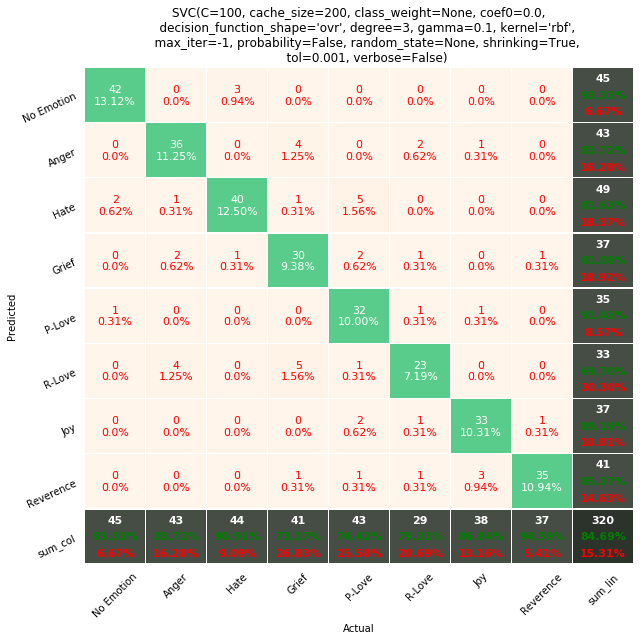

In [0]:
# clf = SVC(kernel = 'rbf', C = 100, gamma = 0.3)
# clf = SVC(kernel = 'linear', C = 100)
print(clf)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

print(confusion_matrix(clf.predict(X_test), y_test))
plot_confusion_matrix_from_data(y_test,clf.predict(X_test), columns=emotion_keys, title = clf,
                                savefig = True, fig_dir = fold_dir, figname = f"MODEL-SVM(linear)-{n_features}-{total_features}-all-features-cm-8-emotions.png")

# print(clf.score(X_test_original, y_test_original))

# plot_confusion_matrix_from_data(y_test_original, clf.predict(X_test_original), columns=emotion_keys, 
#                                 savefig = True, fig_dir = fold_dir, figname = f"MODEL-SVM-{n_features}-all-features-cm-8-emotions.png")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


0.56484375
0.55625
[[32  1 12  2  1  0  0  0]
 [ 0 33  3  8  1  1  0  0]
 [ 6  2  5  3  2  1  0  0]
 [ 0  1  5 17  7  5  3  0]
 [ 4  0 10  3 23  1  5  0]
 [ 0  4  2  5  3 11  1  0]
 [ 2  1  2  2  0  1 22  2]
 [ 1  1  5  1  6  9  7 35]]


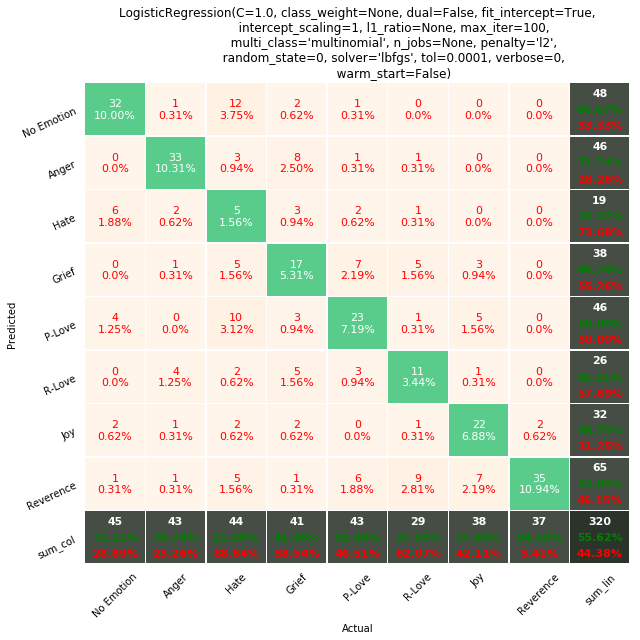

In [0]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

print(confusion_matrix(clf.predict(X_test), y_test))
plot_confusion_matrix_from_data(y_test,clf.predict(X_test), columns=emotion_keys, title = clf,
                                savefig = True, fig_dir = fold_dir, figname = f"MODEL-softmax-{n_features}-{total_features}-all-features-cm-8-emotions.png")

# print(clf.score(X_test_original, y_test_original))

# plot_confusion_matrix_from_data(y_test_original, clf.predict(X_test_original), columns=emotion_keys, 
#                                 savefig = True, fig_dir = fold_dir, figname = "MODEL-softmax-{n_features}-all-features-cm-8-emotions-original-data.png")

In [0]:
clf = KNeighborsClassifier(n_neighbors= 1)

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

print(confusion_matrix(clf.predict(X_test), y_test))

0.6875
[[19  0  2  0  2  0  0  1]
 [ 1 11  0  1  0  0  1  1]
 [ 1  1 18  0  1  0  1  1]
 [ 3  2  0 12  0  3  0  0]
 [ 0  0  1  1 15  3  2  1]
 [ 2  1  0  2  1  6  1  0]
 [ 0  0  0  2  1  6 20  1]
 [ 0  0  0  0  1  0  2  9]]


# Neural network

In [0]:
%tensorflow_version 1.x

from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
def create_model(layers_dim, dropouts, learning_rate = 2e-4, decay = 2e-6, input_dim = 20):
  model = Sequential()
  for dim, dropout_ratio in zip(layers_dim, dropouts):
    model.add(Dense(dim, input_dim = input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_ratio))

  model.add(Dense(8))
  model.add(Activation('softmax'))

  opt = Adam(learning_rate = learning_rate, decay =decay)
  model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])

  return model

In [0]:
"""K fold cross validation"""
KF = KFold(n_splits=10, random_state=None, shuffle=False)
fold = 0
for train_idx, test_idx in KF.split(X_train):    
    print("FOLD: ",fold)
    fold +=1

    layers_dim = [50, 20]
    dropouts = [0.1, 0]
    model = create_model(layers_dim, dropouts, learning_rate= 6e-4, input_dim=20)
    Earlystop = EarlyStopping(monitor = 'val_loss', mode = min, verbose = 1, patience = 500)
    X_train_, y_train_ = X_train[train_idx], y_train[train_idx]
    X_test_, y_test_ = X_train[test_idx], y_train[test_idx]
    H = model.fit(X_train_, y_train_,
              batch_size = 256,
              epochs = 10000,
              # validation_split =1/9,
              validation_data=[X_test_, y_test_],
              shuffle = True,
              verbose = 0,
              callbacks = [Earlystop]
            )
    print(model.evaluate(X_test, y_test))

    plot_confusion_matrix_from_data(np.argmax(y_test, axis = 1),np.argmax(model.predict(X_test), axis = 1), columns=emotion_keys, 
                                    savefig = True, fig_dir = fold_dir, figname = f"Neural-{layers_dim}-{fold}-Fold-{dropouts}-dropout-all-features-cm-8-emotions.png")
    
    # plot_confusion_matrix_from_data(y_test_original,np.argmax(model.predict(X_test_original), axis = 1), columns=emotion_keys, 
    #                                 savefig = True, fig_dir = fold_dir, figname = f"Neural-{layers_dim}-{fold}-Fold-{dropouts}-dropout-all-features-original-data-cm-8-emotions.png")
    plt.plot(H.history['acc'])
    plt.plot(H.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(os.path.join(fold_dir, f"Neural-{layers_dim}-{fold}-{dropouts}-dropout-accuracy_fold-sffs-{n_features}-n-10.png"))
    plt.show()
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(os.path.join(fold_dir, f"Neural-{layers_dim}-{fold}-{dropouts}-dropout-loss_fold-sffs-{n_features}-n-10.png"))
    plt.show()

FOLD:  0


KeyboardInterrupt: ignored

In [0]:
# layers_dim = [16, 16]
# dropouts = [0.1,0.2]
layers_dim = [20]
dropouts = [0.15]
learning_rate =  3e-4
model = create_model(layers_dim, dropouts, learning_rate=learning_rate, decay = 1e-5, input_dim=20)
model.summary()

Earlystop = EarlyStopping(monitor = 'val_loss', mode = min, verbose = 1, patience = 1500)
H = model.fit(X_train, y_train,
              batch_size = 128,
              epochs = 15000,
              # validation_split =1/9,
              validation_data=[X_test, y_test],
              shuffle = True,
              verbose = 0,
            #   callbacks = [Earlystop]
            )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 168       
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
Total params: 588
Trainable params: 588
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.evaluate(X_test, y_test)

320/320 [==============================] - 0s 132us/sample - loss: 0.7872 - acc: 0.7281


[0.7872449219226837, 0.728125]

In [0]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test_number = np.argmax(y_test, axis =1)

In [0]:
print(y_pred)

[0 1 6 1 2 1 2 5 5 5 5 7 7 4 4 4 5 1 1 5 7 0 7 1 4 7 2 2 7 1 5 5 3 3 1 3 4
 6 0 2 7 2 0 5 4 7 5 4 2 0 1 6 2 5 2 2 4 4 2 4 6 4 7 1 7 1 4 4 2 1 6 0 0 7
 1 0 2 1 4 2 7 1 2 4 0 7 2 6 2 4 3 0 1 2 0 3 4 7 0 4 7 6 6 0 0 0 0 3 6 7 6
 7 3 0 4 7 6 3 4 1 7 1 4 0 4 1 5 3 4 6 5 4 0 3 0 6 0 6 2 3 2 0 3 6 2 6 0 7
 3 6 4 4 6 7 4 7 1 6 7 7 1 7 7 2 7 2 2 4 1 6 4 2 3 5 1 7 7 0 5 4 5 2 4 6 5
 7 4 3 7 0 7 3 7 5 5 6 5 5 7 5 7 0 6 2 3 2 7 4 4 1 0 4 4 7 4 1 6 1 1 3 1 0
 7 3 4 1 7 7 1 5 0 1 6 0 7 4 0 7 0 3 0 3 1 5 1 5 2 1 2 0 5 7 6 1 1 5 5 6 4
 0 0 1 3 7 3 0 0 0 6 6 5 4 4 1 5 2 1 2 7 0 5 0 6 0 7 2 1 6 0 5 7 5 5 0 6 0
 1 1 1 5 5 1 5 2 5 2 7 2 2 4 4 3 5 5 6 4 1 2 3 5]


[[39  0  5  0  1  0  0  0]
 [ 0 34  2  7  1  1  0  0]
 [ 1  1 28  0  6  2  0  0]
 [ 0  2  0 20  1  2  0  0]
 [ 2  1  8  5 27  1  1  0]
 [ 1  5  1  8  3 20  1  2]
 [ 2  0  0  0  0  1 30  0]
 [ 0  0  0  1  4  2  6 35]]
0.728125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


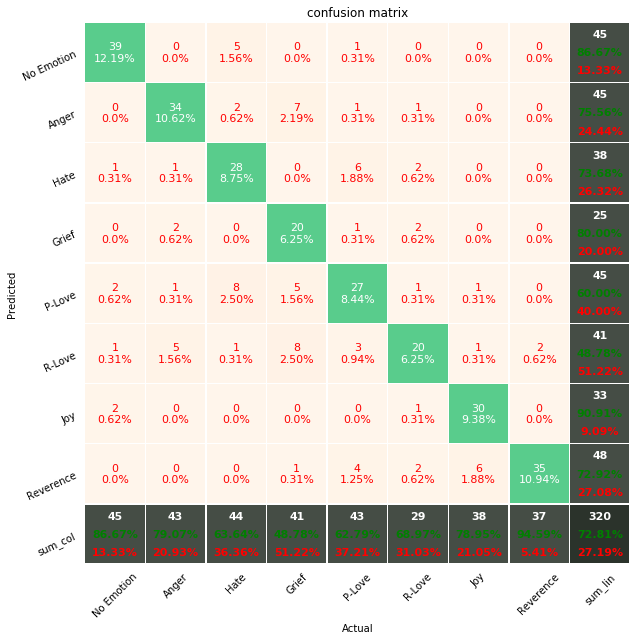

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(confusion_matrix(y_pred, y_test_number))
print(accuracy_score(y_pred, y_test_number))
plot_confusion_matrix_from_data(np.argmax(y_test, axis = 1),np.argmax(model.predict(X_test), axis = 1), columns=emotion_keys, 
                                savefig = True, fig_dir = fold_dir, figname = f"Neural-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-dropout-lr-{learning_rate}-cm-8-emotions.png")

# plot_confusion_matrix_from_data(y_test_original,np.argmax(model.predict(X_test_original), axis = 1), columns=emotion_keys, 
#                                 savefig = True, fig_dir = fold_dir, figname = f"Neural-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-dropout-original-data-cm-8-emotions.png")

In [0]:
H.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

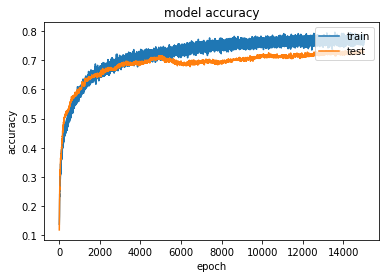

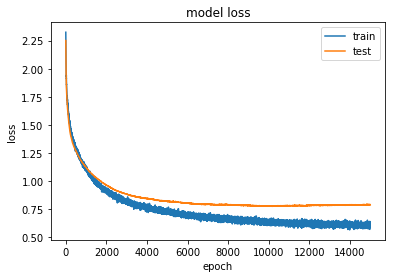

In [0]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

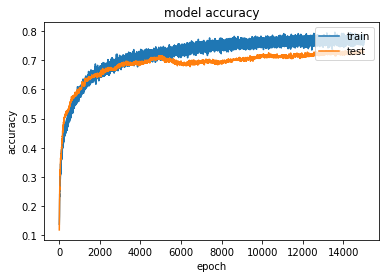

In [0]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join(fold_dir, f"MODEL-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-lr-{learning_rate}-accuracy_{X_test.shape[1]}_features.png"))


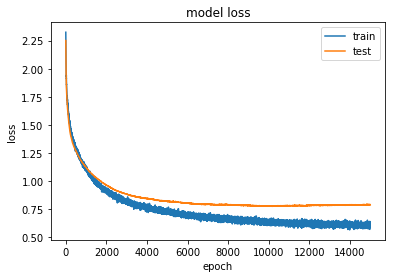

In [0]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join(fold_dir, f"MODEL-{n_features}-{total_features}-features-{layers_dim}-{dropouts}-lr-{learning_rate}-loss_{X_test.shape[1]}_features.png"))

In [0]:
# layers_dim = [16, 16]
# dropouts = [0.1,0.2]
layers_dim = [32]
dropouts = [0]
learning_rate =  5e-3
model = create_model(layers_dim, dropouts, learning_rate=learning_rate, decay = 1e-5, input_dim=20)
model.summary()

Earlystop = EarlyStopping(monitor = 'val_loss', mode = min, verbose = 1, patience = 1500)
H = model.fit(X_train, y_train,
              batch_size = 128,
              epochs = 15000,
              # validation_split =1/9,
              validation_data=[X_test, y_test],
              shuffle = True,
              verbose = 0,
            #   callbacks = [Earlystop]
            )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                672       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 264       
_________________________________________________________________
activation_16 (Activation)   (None, 8)                 0         
Total params: 936
Trainable params: 936
Non-trainable params: 0
_________________________________________________________________
